In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scripts.utils import create_data
from sklearn.decomposition import NMF
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# ==========================
# 1. DATA
# ==========================
X, y = create_data()
random_state = 42

# NMF requires non-negative input
scaler = MinMaxScaler()
X_nonneg = scaler.fit_transform(X)

(70000, 784)
(70000,)


/var/folders/yh/5_x_v8h90_q9yn_jzpz32llw0000gn/T/ipykernel_77794/1217969514.py:26: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 0.95])  # leave space for colorbar


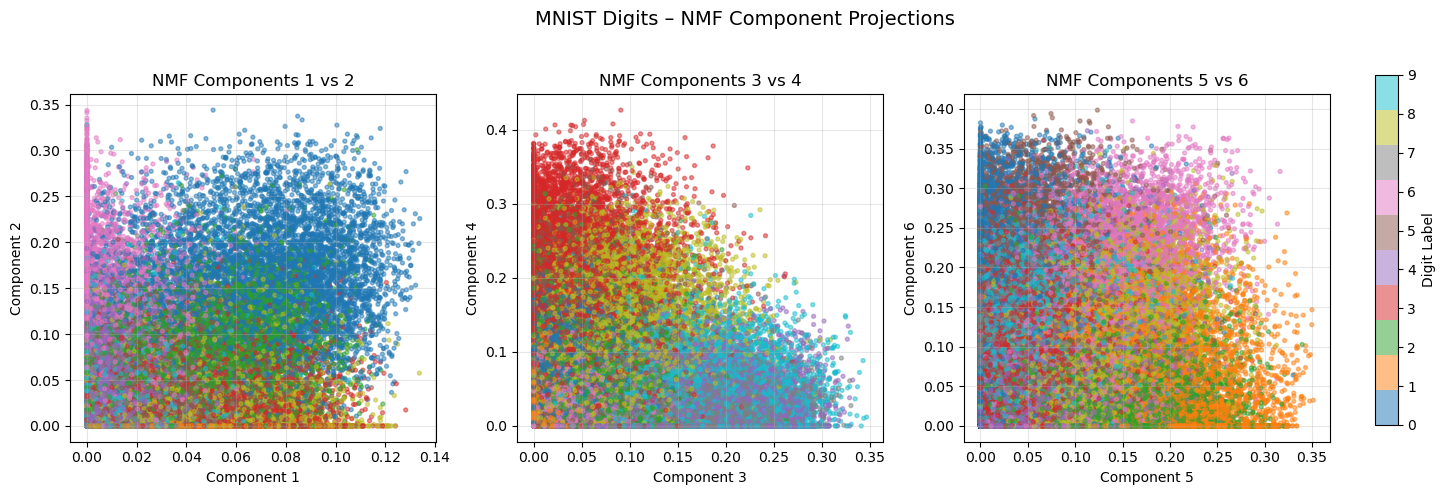

In [8]:
def plot_multiple_nmf_pairs(X, y, path, random_state=42):
    nmf = NMF(n_components=6, init='nndsvda', random_state=random_state, max_iter=500)
    X_nmf = nmf.fit_transform(X)

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    pairs = [(0, 1), (2, 3), (4, 5)]

    for ax, (i, j) in zip(axes, pairs):
        scatter = ax.scatter(X_nmf[:, i], X_nmf[:, j],
                             c=y, cmap="tab10", s=8, alpha=0.5)
        ax.set_xlabel(f"Component {i+1}")
        ax.set_ylabel(f"Component {j+1}")
        ax.set_title(f"NMF Components {i+1} vs {j+1}")
        ax.grid(alpha=0.3)

    # Create colorbar outside the plot
    cbar_ax = fig.add_axes([0.92, 0.15, 0.015, 0.7])  # [left, bottom, width, height]
    cbar = fig.colorbar(scatter, cax=cbar_ax)
    cbar.set_label("Digit Label")

    plt.suptitle("MNIST Digits – NMF Component Projections", fontsize=14)
    plt.tight_layout(rect=[0, 0, 0.9, 0.95])  # leave space for colorbar
    plt.savefig(path, bbox_inches='tight')
    plt.show()

plot_multiple_nmf_pairs(X=X_nonneg, y=y, path='docs/nmf_1x3_components.png')

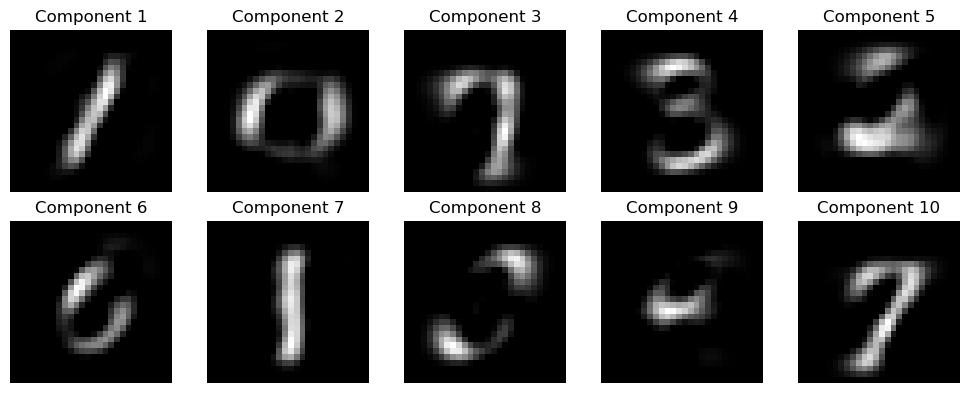

In [14]:
# ==========================
# 3. FEATURE INTERPRETATION
# ==========================
from sklearn.datasets import fetch_openml

mnist = fetch_openml("mnist_784", as_frame=False)
X, y = mnist.data, mnist.target.astype(int)
X_nonneg = MinMaxScaler().fit_transform(X)

nmf = NMF(n_components=10, init='nndsvda', random_state=random_state)
Z = nmf.fit_transform(X_nonneg)
components = nmf.components_

# Visualize first 10 NMF basis components
fig, axes = plt.subplots(2, 5, figsize=(10, 4))
for i, ax in enumerate(axes.flat):
    ax.imshow(components[i].reshape(28, 28), cmap='gray')
    ax.set_title(f"Component {i+1}")
    ax.axis('off')
plt.tight_layout()
plt.savefig('docs/nmf_basis_features2.png')
plt.show()

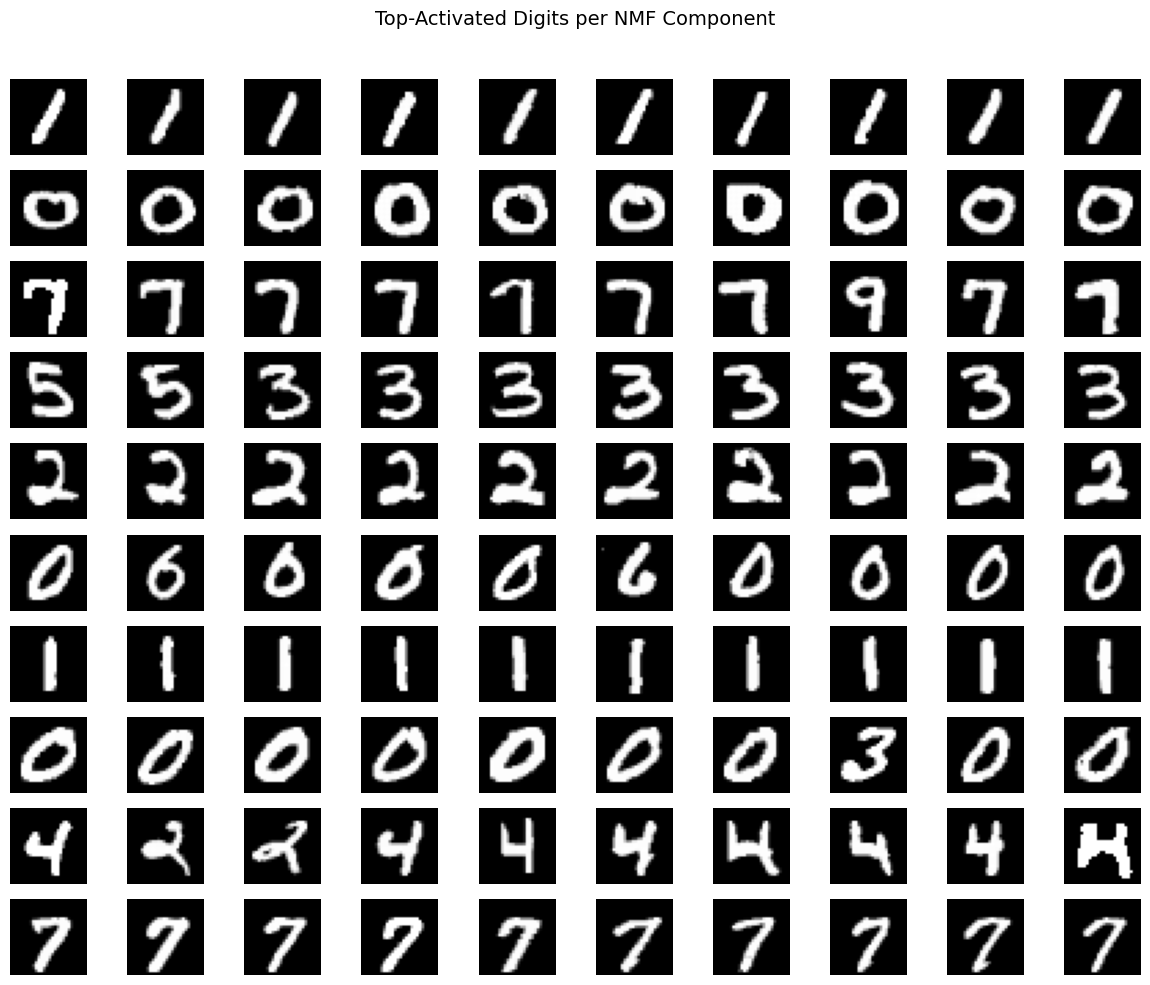

In [15]:
top_k = 10
fig, axes = plt.subplots(10, top_k, figsize=(12, 10))
for i in range(10):
    top_idx = np.argsort(Z[:, i])[::-1][:top_k]
    for j, idx in enumerate(top_idx):
        axes[i, j].imshow(X[idx].reshape(28, 28), cmap='gray')
        axes[i, j].axis('off')
    axes[i, 0].set_ylabel(f"C{i+1}", rotation=0, labelpad=20)
plt.suptitle("Top-Activated Digits per NMF Component", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig('docs/nmf_top_activations_grid2.png')
plt.show()


In [17]:
# ==========================
# 4. HYPERPARAMETER TUNING – SUPERVISED (Optimized)
# ==========================
from sklearn.utils import shuffle

# --- smaller sample for speed ---
X_sample, y_sample = shuffle(X_nonneg, y, random_state=random_state)
X_sample = X_sample[:15000]  # use first 15k observations
y_sample = y_sample[:15000]

X_tr, X_ts, y_tr, y_ts = train_test_split(
    X_sample, y_sample, test_size=0.2, random_state=random_state, stratify=y_sample
)

# --- coarse component grid ---
k_list = [10, 25, 40, 55, 70, 85, 100]
accs = []

best_acc = 0
patience = 2  # early stop if accuracy stagnates twice in a row
no_improve = 0

for k in k_list:
    nmf = NMF(n_components=k, init='nndsvda',
              random_state=random_state, max_iter=250)  # lower max_iter
    Z_tr = nmf.fit_transform(X_tr)
    Z_ts = nmf.transform(X_ts)

    # scaling activations improves classifier stability
    scaler_nmf = StandardScaler()
    Z_tr_scaled = scaler_nmf.fit_transform(Z_tr)
    Z_ts_scaled = scaler_nmf.transform(Z_ts)

    multinomial = LogisticRegression(max_iter=500, n_jobs=-1)
    multinomial.fit(Z_tr_scaled, y_tr)
    iteration_acc = accuracy_score(y_ts, multinomial.predict(Z_ts_scaled))
    accs.append(iteration_acc)
    print(f'NMF iteration complete: k = {k}, accuracy = {iteration_acc:.4f}')

    # --- early stop if accuracy plateaus ---
    if iteration_acc < best_acc + 0.001:
        no_improve += 1
        if no_improve >= patience:
            print("Early stop: accuracy plateau reached.")
            break
    else:
        best_acc = iteration_acc
        no_improve = 0

print("Final accuracies:", dict(zip(k_list[:len(accs)], accs)))


NMF iteration complete: k = 10, accuracy = 0.7993


/opt/anaconda3/lib/python3.12/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 250 reached. Increase it to improve convergence.
  warnings.warn(


NMF iteration complete: k = 25, accuracy = 0.8897


/opt/anaconda3/lib/python3.12/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 250 reached. Increase it to improve convergence.
  warnings.warn(


NMF iteration complete: k = 40, accuracy = 0.8977


/opt/anaconda3/lib/python3.12/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 250 reached. Increase it to improve convergence.
  warnings.warn(


NMF iteration complete: k = 55, accuracy = 0.9107


/opt/anaconda3/lib/python3.12/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 250 reached. Increase it to improve convergence.
  warnings.warn(


NMF iteration complete: k = 70, accuracy = 0.9100


/opt/anaconda3/lib/python3.12/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 250 reached. Increase it to improve convergence.
  warnings.warn(


NMF iteration complete: k = 85, accuracy = 0.9137


/opt/anaconda3/lib/python3.12/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 250 reached. Increase it to improve convergence.
  warnings.warn(


NMF iteration complete: k = 100, accuracy = 0.9127
Final accuracies: {10: 0.7993333333333333, 25: 0.8896666666666667, 40: 0.8976666666666666, 55: 0.9106666666666666, 70: 0.91, 85: 0.9136666666666666, 100: 0.9126666666666666}


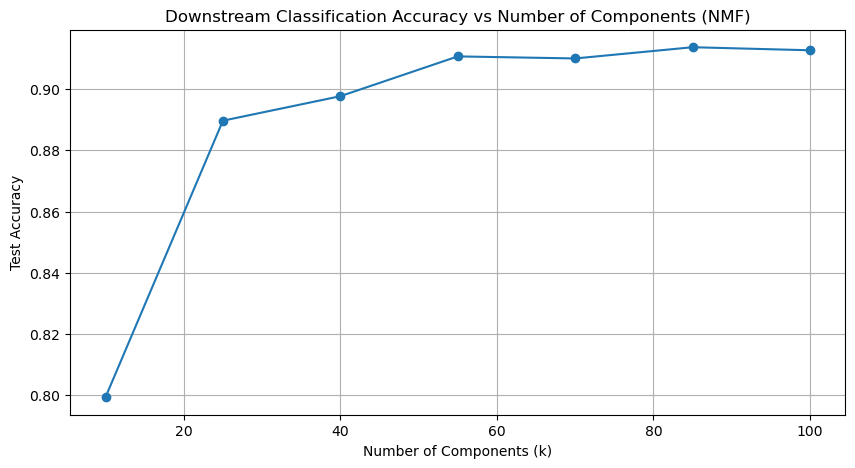

In [18]:
# ==========================
# 5. PLOT ACCURACY CURVE
# ==========================
def plot_classification_accuracy_on_number_of_components(path: str):
    plt.figure(figsize=(10, 5))
    plt.plot(k_list, accs, marker='o')
    plt.xlabel("Number of Components (k)")
    plt.ylabel("Test Accuracy")
    plt.title("Downstream Classification Accuracy vs Number of Components (NMF)")
    plt.grid(True)
    plt.savefig(path)
    plt.show()

plot_classification_accuracy_on_number_of_components(path='docs/hyperparam_tune_supervised_nmf.png')